In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio.v3 as iio

import networkx as nx
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

import dissociation as ds

from collections import deque

plt.style.use("./style.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

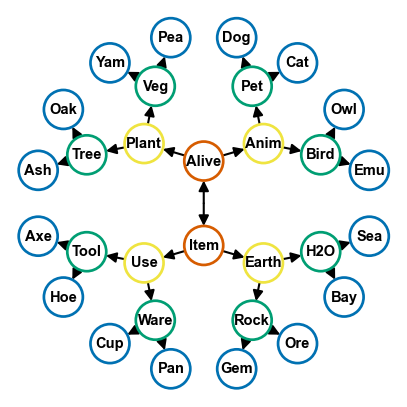

In [2]:
semantic_hierarchy = {
    "": {
        "Alive": {
            "Anim": {
                "Bird": {"Emu": {}, "Owl": {}},
                "Pet": {"Cat": {}, "Dog": {}}
            },
            "Plant": {
                "Veg": {"Pea": {}, "Yam": {}},
                "Tree": {"Oak": {}, "Ash": {}}
            }
        },
        "Item": {
            "Use": {
                "Tool": {"Axe": {}, "Hoe": {}},
                "Ware": {"Cup": {}, "Pan": {}}
            },
            "Earth": {
                "Rock": {"Gem": {}, "Ore": {}},
                "H2O": {"Bay": {}, "Sea": {}}
            }
        }
    }
}

G, pos, dists = ds.create_hierarchical_graph(semantic_hierarchy)
colors_ = [colors[1], colors[1], colors[3], colors[2], colors[0]]

fig, ax = plt.subplots(figsize=(2.6, 2.6))
nx.draw(G, pos, with_labels=True, arrows=True, arrowsize=10, node_size=[0]+[350]*30,
        node_color="w", edgecolors=[colors_[d] for d in dists.values()], linewidths=1.3,
        font_size=7, font_weight="bold", nodelist=list(dists.keys()))

plt.savefig("../figures/fig3/semantic-hierarchy.svg", dpi=300)

In [3]:
def bfs(tree):
    root = next(iter(tree))
    q = deque([(root, tree[root])])
    order = []
    parent = {}
    while q:
        node, children = q.popleft()
        order.append(node)
        for c, sub in children.items():
            parent[c] = node
            q.append((c, sub))
    return order, parent

def ancestors(node):
    return [] if node == "" else ancestors(parent[node]) + [node]

order, parent = bfs(semantic_hierarchy)
leaves = [n for n, p in parent.items() if n not in parent.values()]

dim = len(leaves)
xs = jax.random.normal(jax.random.key(0), (dim, dim)) / np.sqrt(dim)
ys = np.asarray([[1. if node in ancestors(leaf) else 0. for node in order] for leaf in leaves]).T
ys = ys.at[0].set(1.)

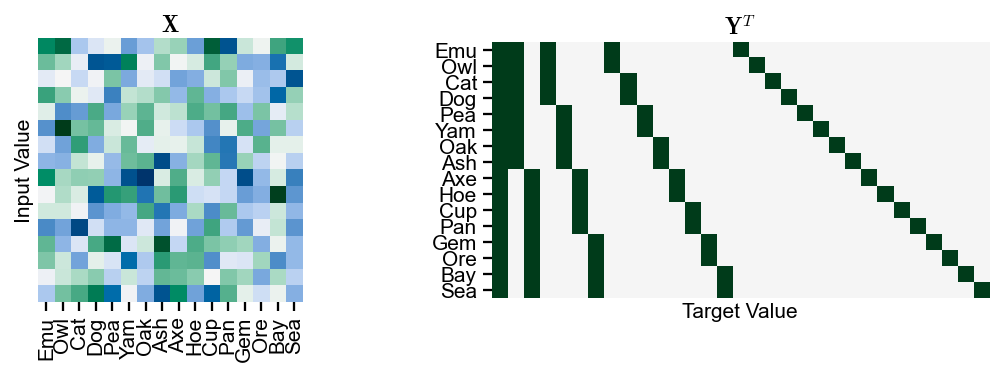

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(2.0*3.6, 2.4))
ax = axs[0]
ax.imshow(xs)
ax.set_title("$\\mathbf{X}$")
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ylabel("Input Value")
ax.set_xticks(range(0, 16))
ax.set_xticklabels(leaves, rotation=90)

ax = axs[1]
ax.imshow(ys.T, vmin=-1, vmax=1.)
ax.set_title("$\\mathbf{Y}^T$")
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel("Target Value")
ax.set_yticks(range(0, 16))
ax.set_yticklabels(leaves)

plt.savefig("../figures/fig3/inputs-and-targets.svg", dpi=300)

In [5]:
elephant = np.asarray(iio.imread('../figures/fig3/16x16-elephant.png'))[:, :, 0]
elephant = elephant - np.mean(elephant)
elephant /= np.std(elephant)
elephant /= 2.

Text(0.5, 0, 'Training Step')

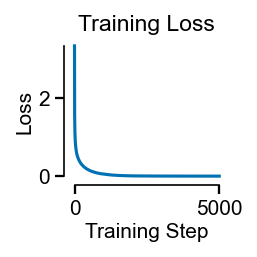

In [6]:
# Least-squares solution
lr = 0.002

def mse(ps, xs, ys):
    w2, w1 = ps
    return np.linalg.norm(w2 @ w1 @ xs - ys, ord="fro")**2

mse_grad = jax.jit(jax.value_and_grad(mse))

w11 = elephant @ xs.T @ np.linalg.pinv(xs @ xs.T + 5e-3 * np.eye(16))
hs = w11 @ xs
w21 = ys @ xs.T @ w11.T @ np.linalg.pinv(hs @ hs.T + 1e-2 * np.eye(16))

losses = []
for i in range(5000):
    l, (dw21, dw11) = mse_grad([w21, w11], xs, ys)
    w11 -= lr * dw11
    w21 -= lr * dw21
    losses.append(l)
    if i in [2000, 3000, 4000]:
        lr /= 2

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("Training Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Training Step")

In [7]:
# Minimum representation-norm solution
m, n, o = ds.compact_svd(ys @ xs.T @ np.linalg.pinv(xs).T)
r = jax.random.orthogonal(jax.random.key(1), 16)
w12 = r @ np.sqrt(n) @ o.T @ np.linalg.pinv(xs)
w22 = m @ np.sqrt(n) @ r.T

# Minimum weight-norm solution
u, s, v = ds.compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))
r = jax.random.orthogonal(jax.random.key(1), 16)
w13 = r @ np.sqrt(s) @ v.T
w23 = u @ np.sqrt(s) @ r.T

print(np.sum(w21 @ w11 @ xs @ xs.T - ys @ xs.T)**2, mse([w21, w11], xs, ys))
print(np.sum(w22 @ w12 @ xs @ xs.T - ys @ xs.T)**2, mse([w22, w12], xs, ys))
print(np.sum(w23 @ w13 @ xs @ xs.T - ys @ xs.T)**2, mse([w23, w13], xs, ys))

0.0011915023 0.0023051414
3.7402177e-05 0.00031437125
0.14409511 0.013803734


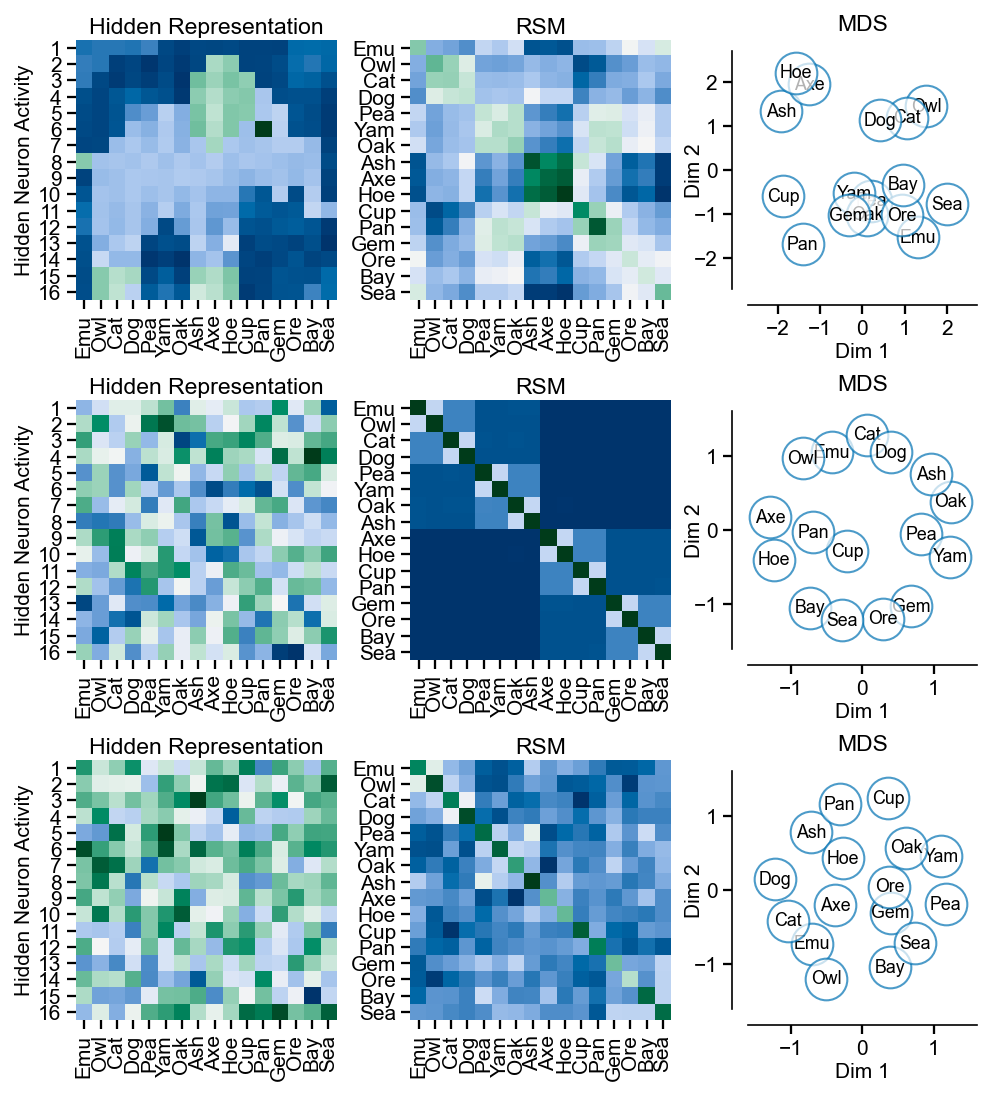

In [8]:
ws = [(w11, w21), (w12, w22), (w13, w23)]

fig, axs = plt.subplots(3, 3, figsize=(2.2*3, 2.4*3))
axs = axs.flatten()
for i, (w1, w2) in enumerate(ws):
    ax = axs[(i*3)]
    ax.imshow(w1 @ xs)
    ax.set_title("Hidden Representation")
    ax.set_xticks(range(16))
    ax.set_xticklabels(leaves, rotation=90)
    ax.set_yticks(range(0, 16))
    ax.set_yticklabels(range(1, 17))
    ax.set_ylabel("Hidden Neuron Activity")
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax = axs[(i*3)+1]
    ax.imshow(xs.T @ w1.T @ w1 @ xs)
    ax.set_title("RSM")
    ax.set_xticks(range(0, 16))
    ax.set_xticklabels(leaves, rotation=90)
    ax.set_yticks(range(0, 16))
    ax.set_yticklabels(leaves)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax = axs[(i*3)+2]
    distances = pdist(jax.device_get(w1 @ xs).T, metric='euclidean')
    distance_matrix = squareform(distances)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0, n_init=4)
    fit = mds.fit_transform(distance_matrix)
    ax.set_title("MDS", pad=-10)
    for item in range(16):
        ax.scatter(fit[item, 0], fit[item, 1], color="w", edgecolor=colors[0], s=400, zorder=item, alpha=0.7)
        ax.text(fit[item, 0], fit[item, 1], leaves[item], ha="center", va="center", zorder=item, fontsize=8.5)
    xlim, ylim = np.max(np.abs(fit), axis=0)* 1.3

    if i == 0:
        lim = 2.7
        ax.set_xticks([-2, -1, 0, 1, 2])
        ax.set_yticks([-2, -1, 0, 1, 2])
    else:
        lim = 1.6
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([-1, 0, 1])
    ax.set_xlim(-lim , lim)
    ax.set_ylim(-lim , lim)
    ax.set_ylabel("Dim 2", labelpad=-5)
    ax.set_xlabel("Dim 1")
    
plt.savefig("../figures/fig3/h-rsm-mds.svg", dpi=300)